<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Unsupervised Machine Learning - Final Assignment</font></h1>


# Introduction

The aim of this workbook is to use unsupervised learning to draw insights from a dataset.

# Lib Import

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
from sklearn.cluster import KMeans, DBSCAN, MeanShift

# Dataset Info

__name:__ Bank Customer Segmentation (1M+ Transactions)\
__source:__ Kaggle\
__url:__ https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

Context
The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones).

https://www.kaggle.com/code/yuvraj5857/exploring-bank-transaction-dataset-using-pyspark#2.-Data-Transformation-and-Cleaning

## 1. EDA

### 1.1 Dataset Loading

In [44]:
df = pd.read_csv('bank_transactions.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


First step is to check for missing or null values.

In [45]:
(df.isna().sum() / len(df)) * 100

TransactionID              0.000000
CustomerID                 0.000000
CustomerDOB                0.323966
CustGender                 0.104905
CustLocation               0.014401
CustAccountBalance         0.225927
TransactionDate            0.000000
TransactionTime            0.000000
TransactionAmount (INR)    0.000000
dtype: float64

There do seem to be missing entries but they are all below 1%, so I think I will drop them from the dataset.

In [46]:
df.dropna(inplace=True)

In [47]:
df.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

Now I will review the datatypes of the columns.

In [48]:
df.dtypes

TransactionID               object
CustomerID                  object
CustomerDOB                 object
CustGender                  object
CustLocation                object
CustAccountBalance         float64
TransactionDate             object
TransactionTime              int64
TransactionAmount (INR)    float64
dtype: object

Initial insight is that there seem to be some columns which are currently represented as objects, but can be represented numerically either via encoding or as time / date, which will be done during the Feature Engineering step.

I will quickly review the distribution of the TransactionID and CustomerID columns.

In [49]:
transaction_id_vc = df['TransactionID'].value_counts()
transaction_id_vc

TransactionID
T1          1
T699342     1
T699328     1
T699329     1
T699330     1
           ..
T349709     1
T349710     1
T349711     1
T349712     1
T1048567    1
Name: count, Length: 1041614, dtype: int64

In [50]:
transaction_id_vc[transaction_id_vc > 1]

Series([], Name: count, dtype: int64)

So the TransactionID appears to be unique to each entry, so this can probably be removed.

In [51]:
customer_id_vc = df['CustomerID'].value_counts()
customer_id_vc

CustomerID
C5533885    6
C7537344    6
C1736254    6
C1113684    6
C4327447    6
           ..
C1610768    1
C4929259    1
C1026114    1
C6817889    1
C6420483    1
Name: count, Length: 879358, dtype: int64

In [52]:
customer_id_vc[customer_id_vc > 1]

CustomerID
C5533885    6
C7537344    6
C1736254    6
C1113684    6
C4327447    6
           ..
C2239666    2
C5811913    2
C1635174    2
C6229976    2
C6442630    2
Name: count, Length: 141961, dtype: int64

The CustomerID has some instances where there are more than one value, so this can stay in the dataset.

### 1.2 Data Preprocessing

Tasks in this step include:

1. Removing unnecessary columns
2. Encoding or converting object classes
3. Normalizing numerical classes

In [53]:
df.drop('TransactionID', axis=1, inplace=True)

The next step is to convert the object columns which are dates to actual date values.

In [54]:
df.head()

,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [55]:
DATE_COLUMNS = ['CustomerDOB', 'TransactionDate']

In [56]:
df[DATE_COLUMNS] = df[DATE_COLUMNS].astype('datetime64[ns]')
df[DATE_COLUMNS].head()

KeyboardInterrupt: 

Next step is to convert Gender from an object to labels.

In [ ]:
df['CustGender'] = df['CustGender'].apply(lambda x: 0 if x == 'M' else 1)
df['CustGender'].unique()

array([1, 0])

__Acceptable Date Ranges__


Finally need to check to make sure there are no abnormal dates.

In [ ]:
df['CustomerDOB'].max()
df['CustomerDOB'].min()

Timestamp('1800-01-01 00:00:00')

In [ ]:
acceptable_customer_dob = (df['CustomerDOB'] == '1800-01-01 00:00:00') | (df['CustomerDOB'] == '2073-12-31 00:00:00')
df[acceptable_customer_dob]

,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
16,C1376215,1800-01-01,0,MUMBAI,77495.15,2016-01-08,124727,1423.11
22,C7018081,1800-01-01,0,WAYS PANCHKUVA AHMEDABAD,143.07,2016-03-08,104718,110.00
28,C7935438,1800-01-01,0,MOHALI,969436.12,2016-03-08,183634,36.90
35,C1211387,1800-01-01,0,AHMEDABAD,11791.25,2016-03-08,125915,1075.00
151,C3334638,1800-01-01,0,PUNE,700.00,2016-09-08,24912,1500.00
...,...,...,...,...,...,...,...,...
1048443,C7261226,1800-01-01,0,BHILAI,1393.33,2016-09-18,102427,200.00
1048452,C3813481,1800-01-01,0,NEW DELHI,984605.24,2016-09-18,84644,219.00
1048531,C6937679,1800-01-01,0,NEW DELHI,50698.90,2016-09-18,184319,598.86
1048533,C7431884,1800-01-01,0,MANDIR DHANBAD,53771.64,2016-09-18,184049,520.00


In [ ]:
df.drop(df[acceptable_customer_dob].index, inplace=True)

In [ ]:
df.head()

,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,C5841053,1994-10-01,1,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0
1,C2142763,2057-04-04,0,JHAJJAR,2270.69,2016-02-08,141858,27999.0
2,C4417068,1996-11-26,1,MUMBAI,17874.44,2016-02-08,142712,459.0
3,C5342380,2073-09-14,1,MUMBAI,866503.21,2016-02-08,142714,2060.0
4,C9031234,1988-03-24,1,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5


In [ ]:
df['TransactionDate'].min()

Timestamp('2016-01-08 00:00:00')

In [ ]:
df['TransactionDate'].max()

Timestamp('2016-12-09 00:00:00')

Transaction dates seem to be fine.

__Location Trimming and Encoding__

In [ ]:
unique_locations = df['CustLocation'].unique()
print(f"num unique locations: {len(unique_locations)}")
unique_locations

num unique locations: 8164


array(['JAMSHEDPUR', 'JHAJJAR', 'MUMBAI', ..., 'IRVINE', 'KARANJIA',
       'IMPERIA THANE WEST'], dtype=object)

There are two many locations to use categorical encoding, as this will introduce too many features into the dataset. I've noticed that there are some locations that have brackets in the name, so maybe these can be excluded.

In [ ]:
bracketed_locations = [loc for loc in unique_locations if loc.find('(') != -1]
print(f"num bracketed locations {len(bracketed_locations)}")

num bracketed locations 328


These aren't much help. Ill do a value counts to see how many non unique values there are.

In [ ]:
loc_value_counts = df['CustLocation'].value_counts() / len(df) * 100
loc_value_counts

CustLocation
MUMBAI                       9.913842
BANGALORE                    7.891267
NEW DELHI                    7.752017
GURGAON                      7.157161
DELHI                        6.834105
                               ...   
KAMALPUR                     0.000101
JUFFAIR                      0.000101
CHAKALA ANDHERI -E MUMBAI    0.000101
CORPORATION THANE            0.000101
IMPERIA THANE WEST           0.000101
Name: count, Length: 8164, dtype: float64

Reviewing this, I think it may be worth removing anything with less than 0.125% of the entries in the dataset, otherwise categorization is too difficult.

In [ ]:
locations_percentage_threshold = loc_value_counts[loc_value_counts >= 0.125]

In [ ]:
allowed_locations = locations_percentage_threshold.index.to_list()
allowed_locations

['MUMBAI',
 'BANGALORE',
 'NEW DELHI',
 'GURGAON',
 'DELHI',
 'NOIDA',
 'CHENNAI',
 'PUNE',
 'HYDERABAD',
 'THANE',
 'KOLKATA',
 'GHAZIABAD',
 'NAVI MUMBAI',
 'AHMEDABAD',
 'FARIDABAD',
 'JAIPUR',
 'CHANDIGARH',
 'LUCKNOW',
 'MOHALI',
 'SURAT',
 'NASHIK',
 'LUDHIANA',
 'VISAKHAPATNAM',
 'DEHRADUN',
 'INDORE',
 'VADODARA',
 'AMRITSAR',
 'AGRA',
 'KANPUR',
 'NAGPUR',
 'MEERUT',
 'COIMBATORE',
 'GREATER NOIDA',
 'PANCHKULA',
 'AURANGABAD',
 'GUNTUR',
 'GUWAHATI',
 'RANGA REDDY',
 'JALANDHAR',
 'BHOPAL',
 'PATNA',
 'UDAIPUR',
 'ERNAKULAM',
 'RANCHI',
 'REWARI',
 'BENGALURU',
 'HOWRAH',
 'PATIALA',
 'SECUNDERABAD',
 'ALWAR',
 'ALLAHABAD',
 'NORTH 24 PARGANAS',
 'SONIPAT',
 'PANIPAT',
 'BAMBOLIM',
 'ZIRAKPUR',
 'RAJKOT',
 'RAIPUR',
 'KOLHAPUR',
 'SILIGURI',
 'BAREILLY',
 'JAMSHEDPUR',
 'ALIGARH',
 'KARNAL',
 'MANGALORE',
 'KANGRA',
 'WARANGAL',
 'SAHARANPUR',
 'HOSUR',
 'KOTTAYAM',
 'AMBALA',
 'KHARAR',
 'MORADABAD']

Removing unnecessary Locations and birthdays.

In [ ]:
allowed_location_mask = (df['CustLocation'].isin(allowed_locations))

In [ ]:
final_df = df[allowed_location_mask]

In [ ]:
print(f"percentage change in: {((len(df) - len(final_df)) / len(df)) * 100}")

percentage change in: 24.415622377011996


In [ ]:
final_df

Losing about 24% of observations which isn't ideal but it will do for now.

In [31]:
location_dummies = pd.get_dummies(final_df['CustLocation']).astype(int)
location_dummies

,AGRA,AHMEDABAD,ALIGARH,ALLAHABAD,ALWAR,AMBALA,AMRITSAR,AURANGABAD,BAMBOLIM,BANGALORE,...,SECUNDERABAD,SILIGURI,SONIPAT,SURAT,THANE,UDAIPUR,VADODARA,VISAKHAPATNAM,WARANGAL,ZIRAKPUR
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [32]:
final_df = pd.concat([final_df, location_dummies], ignore_index=True)

In [33]:
final_df.drop('CustLocation', axis=1, inplace=True)

In [34]:
final_df.head()

,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),AGRA,AHMEDABAD,ALIGARH,...,SECUNDERABAD,SILIGURI,SONIPAT,SURAT,THANE,UDAIPUR,VADODARA,VISAKHAPATNAM,WARANGAL,ZIRAKPUR
0,C5841053,1994-10-01,1.0,17819.05,2016-02-08,143207.0,25.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C4417068,1996-11-26,1.0,17874.44,2016-02-08,142712.0,459.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C5342380,2073-09-14,1.0,866503.21,2016-02-08,142714.0,2060.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C9031234,1988-03-24,1.0,6714.43,2016-02-08,181156.0,1762.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C7126560,1992-01-26,1.0,973.46,2016-02-08,173806.0,566.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3 EDA

__Numerical Column Distribution and Analysis__

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
NUMERICAL_COLS = ['CustAccountBalance', 'TransactionAmount (INR)']

In [37]:
#ss = MinMaxScaler()
#final_df[NUMERICAL_COLS] = ss.fit_transform(final_df[NUMERICAL_COLS])
#final_df[NUMERICAL_COLS].head()

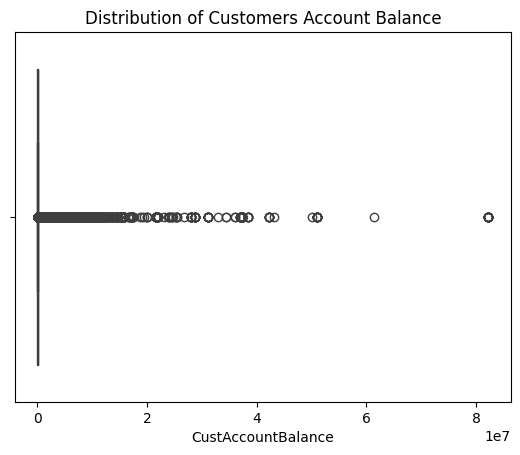

In [38]:
sns.boxplot(final_df, x='CustAccountBalance')
plt.title('Distribution of Customers Account Balance')
plt.show()

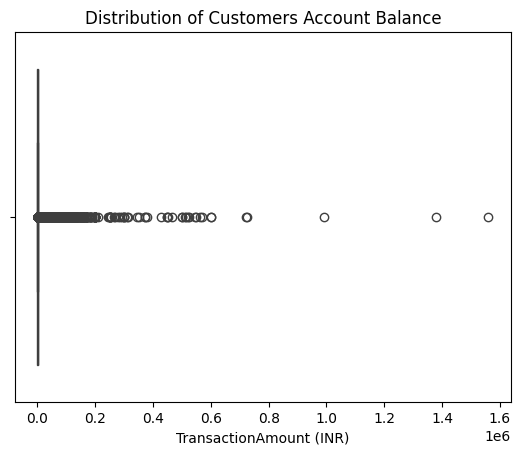

In [39]:
sns.boxplot(final_df, x='TransactionAmount (INR)')
plt.title('Distribution of Customers Account Balance')
plt.show()

<BarContainer object of 20 artists>

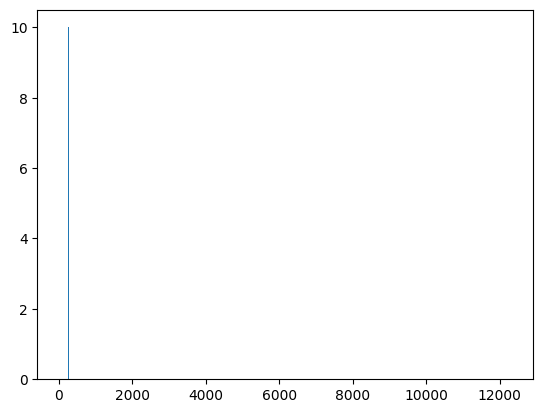

In [40]:
plt.bar(final_df['TransactionAmount (INR)'][:20], height=10)